## Insights from Baby Names Data

#### Author Information:

Oguz Semerci<br>
oguz.semerci@gmail.com<br>

### Summary of the investigation

We report on descriptive satistics as well as a few insights mined from a data set of state by state baby name counts from 1910 to 2014. We present the following descriptive statistics:

- The most popular male and female names of all time
- favorite gender-neutral names in 1945 and 2013
- Names with biggest decreae and increase in popularity since 1980

We extract the following insights from the dataset:

- Increase in pupularity of gender ambigious names
- Correlation in the increaed tendency in using gender-neutral names with landmark events leading the legalization of same-sex marriage
- Dimentionality reduction (***randomized PCA***) of the data, comments on first tow principle components and ***K-means*** clustering of the states.


### I- Data Preperation

Here we quote the official description of the data aset:

>For each of the 50 states and the District of Columbia we created a file called SC.txt, where SC is the state's postal code.

>Each record in a file has the format: 2-digit state code, sex (M = male or F = female), 4-digit year of birth (starting with 1910), the 2-15 character name, and the number of occurrences of the name. Fields are delimited with a comma. Each file is sorted first on sex, then year of birth, and then on number of occurrences in descending order. When there is a tie on the number of occurrences names are listed in alphabetical order. This sorting makes it easy to determine a name's rank. The first record for each sex & year of birth has rank 1, the second record has rank 2, and so forth.

>To safeguard privacy, we restrict our list of names to those with at least 5 occurrences. If a name has less than 5 occurrences for a year of birth in any state, the sum of the state counts for that year will be less than the national count.</q>"

One can say the data sets look clean except for some ambiguities in baby names. For example in RI data we have the following for the year 1992:

- RI,F,1992,Kaitlyn,37
- RI,F,1992,Katelyn,36

One might argue that both versions of the name Katelyn are phonetically the same and sould be counted together. And if they were to be counted together that would change the rank of the name Katelyn about 10 levels. Normalizing the data for such instances is out of the scope of this analysis. However, we'll keep it in mind when analyzing the results.

Below, we sequentially process each file and extract relevant data without loading all data to memory at once. Let's first fet a list of all the file names:

In [1]:
import os
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data_folder = os.path.join('data')
file_names = []
for f in os.listdir(data_folder):
    file_names.append(os.path.join(data_folder,f))
del file_names[file_names.index(os.path.join(data_folder,'StateReadMe.pdf'))]

### II- Predictive Analysis

#### II-1 Most popular name of all time

In [2]:
# we yearly count data for each name in the data set using the following dictionary format :
# dict = {'name': {count: []}} where count[0] is count for name 1910 and count[-1] is for 2014
N_years = 2014-1910+1
names_dict_M = {}
names_dict_F = {}
for fname in file_names:
    with open(fname,'r') as f:
        for line in f:
            
            state, gender, year, name, count = line.split(',')
            year = int(year)
            count = int(count)
            
            if gender == 'M':            
                if name in names_dict_M:
                    # name already in the dict, update the count for appropriate year
                    names_dict_M[name]['count'][year-1910] += count
                else:
                    # create an entry for the name
                    names_dict_M[name] = {'count': [0]*N_years}
                    names_dict_M[name]['count'][year-1910] += count
                    
            elif gender == 'F':
                if name in names_dict_F:
                    # name already in the dict, update the count for appropriate year
                    names_dict_F[name]['count'][year-1910] += count
                else:
                    # create an entry for the name
                    names_dict_F[name] = {'count': [0]*N_years}
                    names_dict_F[name]['count'][year-1910] += count

Now, let's find the most popular male and female names of all times:

In [3]:
#lets extract tuples as (name, total_count) and sort them
male_overall   = [(n, sum(names_dict_M[n]['count'])) for n in names_dict_M.keys()]
male_overall.sort(key = lambda x: x[1], reverse = True)

female_overall   = [(n, sum(names_dict_F[n]['count'])) for n in names_dict_F.keys()]
female_overall.sort(key = lambda x: x[1], reverse = True)

And the winner for most popular male and female baby names since 1910 are:

Male:
James: 4938965

Female:
Mary: 3730856


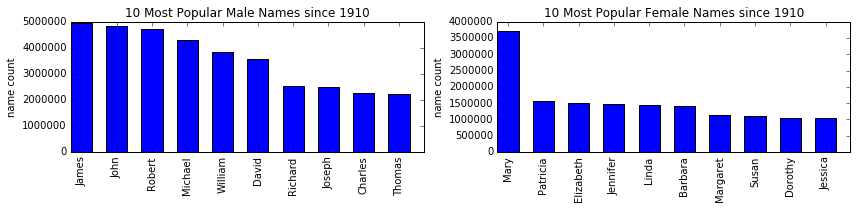

In [4]:
print('Male:')
print('{}: {}'.format(male_overall[0][0], male_overall[0][1]))

print('\nFemale:')
print('{}: {}'.format(female_overall[0][0], female_overall[0][1]))
    
width = 0.6
fig = plt.figure(figsize = (12,3))
ax  = plt.subplot(121)
ax.bar(np.arange(10), [c for n,c in male_overall[:10]], width = width)
ax.set_xticks(np.arange(10) + width/2)
ax.set_xticklabels([n for n,c in male_overall[:10]], rotation = 90)
ax.set_title('10 Most Popular Male Names since 1910')
ax.set_ylabel('name count')

ax  = plt.subplot(122)
ax.bar(np.arange(10), [c for n,c in female_overall[:10]], width = width)
ax.set_xticks(np.arange(10) + width/2)
ax.set_xticklabels([n for n,c in female_overall[:10]], rotation = 90)
ax.set_title('10 Most Popular Female Names since 1910')
ax.set_ylabel('name count')
plt.tight_layout()
plt.show()

- The winner in the male category is James. 493865 baby boys were named 'James' from 1910 to 2014.
- On the female side 'Mary' is the winner. 3730856 baby girls were named 'Mary' from 1910 to 2014.

#### II-2 Most Gender Ambigious Name in 2013 and 1945

We quantify the popularity of a gender ambigious name with 'name' in year x by: Minimum of {number of male babies born in year x with name 'name', number of female babies born in year x with name 'name'}

In [5]:
#lets extract tuples as (name, count[2013]) and sort them with count
male_2013   = [(n, names_dict_M[n]['count'][2013-1910]) 
               for n in names_dict_M.keys() 
               if names_dict_M[n]['count'][2013-1910] > 0]

female_2013 = [(n, names_dict_F[n]['count'][2013-1910]) 
               for n in names_dict_F.keys() 
               if names_dict_F[n]['count'][2013-1910] > 0]

male_1945 = [(n, names_dict_M[n]['count'][1945-1910]) 
             for n in names_dict_M.keys() 
             if names_dict_M[n]['count'][1945-1910] > 0]

female_1945 = [(n, names_dict_F[n]['count'][1945-1910]) 
               for n in names_dict_F.keys() 
               if names_dict_F[n]['count'][1945-1910] > 0]

In 2013 there were 499 gender ambigious names and are the most popular ones was Riley
In 1945 there were 237 gender ambigious names and are the most popular ones was Willie


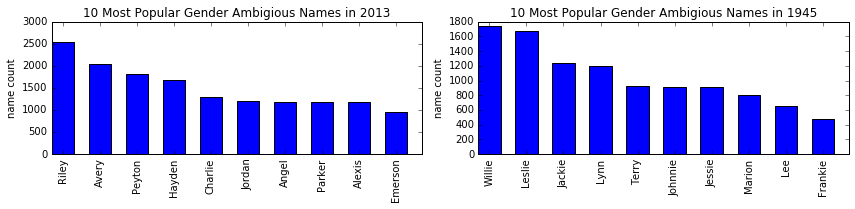

In [6]:
#first find gender ambigious names in 2013:
gender_ambigious_names = set([n for n, _ in male_2013]) & set([n for n, _ in female_2013])
gender_ambigious_names = [(
                            n,min(names_dict_M[n]['count'][2013-1910],
                                      names_dict_F[n]['count'][2013-1910])
                           ) 
                           for n in gender_ambigious_names]
#sort the tuples such that most popular names are at top
gender_ambigious_names.sort(key = lambda x: x[1], reverse = True)

print('In 2013 there were {} gender ambigious names and are the most popular ones was {}'
      .format(len(gender_ambigious_names), gender_ambigious_names[0][0]))

width = 0.6
fig = plt.figure(figsize = (12,3))
ax  = plt.subplot(121)
ax.bar(np.arange(10), [c for n,c in gender_ambigious_names[:10]], width = width)
ax.set_xticks(np.arange(10) + width/2)
ax.set_xticklabels([n for n,c in gender_ambigious_names[:10]], rotation = 90)
ax.set_title('10 Most Popular Gender Ambigious Names in 2013')
ax.set_ylabel('name count')


gender_ambigious_names = set([n for n, _ in male_1945]) & set([n for n, _ in female_1945])
gender_ambigious_names = [(
                            n,min(names_dict_M[n]['count'][1945-1910],
                                  names_dict_F[n]['count'][1945-1910])
                           ) 
                          for n in gender_ambigious_names]
#sort the tuples such that most popular names are at top
gender_ambigious_names.sort(key = lambda x: x[1], reverse = True)

print('In 1945 there were {} gender ambigious names and are the most popular ones was {}'
      .format(len(gender_ambigious_names), gender_ambigious_names[0][0]))
    
ax2  = plt.subplot(122)
ax2.bar(np.arange(10), [c for n,c in gender_ambigious_names[:10]], width = width)
ax2.set_xticks(np.arange(10) + width/2)
ax2.set_xticklabels([n for n,c in gender_ambigious_names[:10]], rotation = 90)
ax2.set_title('10 Most Popular Gender Ambigious Names in 1945')
ax2.set_ylabel('name count')
plt.tight_layout()
plt.show()

It is intesting to notice number gender ambigious names more than doubles since 1945. I believe this is a general trend which could more predominantly observerd in liberal and urban cities in the US.

#### II-3,4 Names with largest decrease and increase in number since 1980

In [7]:
male_diff   = [ (n, names_dict_M[n]['count'][-1] - names_dict_M[n]['count'][1980-1910]) for n in names_dict_M.keys() ]
female_diff = [ (n, names_dict_F[n]['count'][-1] - names_dict_F[n]['count'][1980-1910]) for n in names_dict_F.keys() ]

male_diff.sort(key = lambda x: x[1], reverse = True)
female_diff.sort(key = lambda x: x[1], reverse = True)

print('Male name with most increase in popularity is {}'.format(male_diff[0][0]))
print('Count for {} increased from {} to {} from 1980 to 2014'.format(male_diff[0][0],
                                                                     names_dict_M[male_diff[0][0]]['count'][1980-1910],
                                                                     names_dict_M[male_diff[0][0]]['count'][-1]))

print('\nFemale name with most increase in popularity is {}'.format(female_diff[0][0]))
print('Count for {} increased from {} to {} from 1980 to 2014'.format(female_diff[0][0],
                                                                     names_dict_F[female_diff[0][0]]['count'][1980-1910],
                                                                     names_dict_F[female_diff[0][0]]['count'][-1]))


print('\nMale name with most deccrease in popularity is {}'.format(male_diff[-1][0]))
print('Count for {} decreased from {} to {} from 1980 to 2014'.format(male_diff[-1][0],
                                                                     names_dict_M[male_diff[-1][0]]['count'][1980-1910],
                                                                     names_dict_M[male_diff[-1][0]]['count'][-1]))

print('\nFemale name with most deccrease in popularity is {}'.format(female_diff[-1][0]))
print('Count for {} decreased from {} to {} from 1980 to 2014'.format(female_diff[-1][0],
                                                                     names_dict_F[female_diff[-1][0]]['count'][1980-1910],
                                                                     names_dict_F[female_diff[-1][0]]['count'][-1]))

Male name with most increase in popularity is Liam
Count for Liam increased from 71 to 18342 from 1980 to 2014

Female name with most increase in popularity is Emma
Count for Emma increased from 482 to 20799 from 1980 to 2014

Male name with most deccrease in popularity is Michael
Count for Michael decreased from 68666 to 15323 from 1980 to 2014

Female name with most deccrease in popularity is Jennifer
Count for Jennifer decreased from 58385 to 1499 from 1980 to 2014


#### II-5 Other Names with largest decrease and increase in number since 1980

Let's see for what other names large differentials are observed betseen 1980 and 2014.

In [8]:
print('Male names with largest increase in popularity along with increase rate:')
for n, c in male_diff[:5]:
    print('{}: {}'.format(n,c))

print('\nFemale names with largest increase in popularity along with increase rate:')
for n, c in female_diff[:5]:
    print('{}: {}'.format(n,c))
    
print('\nMale names with largest decrease in popularity along with decrease rate:')
for n, c in male_diff[-1:-5:-1]:
    print('{}: {}'.format(n,c))

print('\nFemale names with largest decrease in popularity along with decrease rate:')
for n, c in female_diff[-1:-5:-1]:
    print('{}: {}'.format(n,c))

Male names with largest increase in popularity along with increase rate:
Liam: 18271
Noah: 18245
Mason: 16795
Ethan: 14948
Aiden: 13296

Female names with largest increase in popularity along with increase rate:
Emma: 20317
Olivia: 18584
Sophia: 17906
Isabella: 16927
Ava: 15525

Male names with largest decrease in popularity along with decrease rate:
Michael: -53343
Jason: -42666
Christopher: -38808
David: -29835

Female names with largest decrease in popularity along with decrease rate:
Jennifer: -56886
Amanda: -34808
Jessica: -32166
Melissa: -30165


### III- Insights

#### III-1 Trend in the number of gender ambigious names

As mentioned in Section II-2 we expect the number of gender ambigious names to increase over the years. That trend is most probably related to changes in perspective of the society in the gender-equality issues. But let's not pretend to be a sociologist here:). Below, we plot the trend as well as a linear fit to the trend.

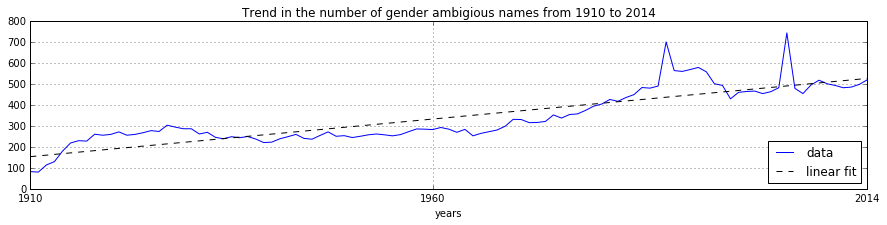

In [9]:
count = [0]*(2014-1910+1)
for year in range(0,2014-1910+1):
    
    male_names   = [n for n in names_dict_M.keys() if names_dict_M[n]['count'][year] > 0]
    female_names = [n for n in names_dict_F.keys() if names_dict_F[n]['count'][year] > 0]
    count[year] = len(set(male_names) & set(female_names))

fit = np.polyfit(range(0,2014-1910+1),count,1)
fit_fn = np.poly1d(fit)
    
fig = plt.figure(figsize = (15,3))
plt.plot(range(0,2014-1910+1), count, label = 'data')
plt.plot(range(0,2014-1910+1), fit_fn(range(0,2014-1910+1)), '--k', label = 'linear fit')
plt.legend(loc = 'lower right')
plt.title('Trend in the number of gender ambigious names from 1910 to 2014')
plt.xticks([0,1960-1910,2014-1910], ['1910', '1960', '2014'])
plt.xlabel('years')
plt.xlim([0,2014-1910])
plt.grid()
plt.show()

In [10]:
print('There is peak in yer {}.'.format(1910 + count.index(max(count))))

#what are the most popular gender ambigious names in 2004:
male_2004   = [(n, names_dict_M[n]['count'][2004-1910]) 
               for n in names_dict_M.keys() 
               if names_dict_M[n]['count'][2004-1910] > 0]

female_2004 = [(n, names_dict_F[n]['count'][2004-1910]) 
               for n in names_dict_F.keys() 
               if names_dict_F[n]['count'][2004-1910] > 0]

gender_ambigious_names = set([n for n, _ in male_2004]) & set([n for n, _ in female_2004])
gender_ambigious_names = [(
                            n,min(names_dict_M[n]['count'][1945-1910],
                                  names_dict_F[n]['count'][1945-1910])
                           ) 
                          for n in gender_ambigious_names]
#sort the tuples such that most popular names are at top
gender_ambigious_names.sort(key = lambda x: x[1], reverse = True)

print('In 2014 there were {} gender ambigious names and here are the most popular ones:'
      .format(len(gender_ambigious_names)))
for n,c in gender_ambigious_names[:3]:
    print('{}: {}'.format(n,c))

There is peak in yer 2004.
In 2014 there were 745 gender ambigious names and here are the most popular ones:
Leslie: 1678
Jackie: 1245
Terry: 927


A quick google seaerch revealst that in 2003 and 2004 landmark years in the process of leagalization of same-sex marriage:

> Goodridge v. Dept. of Public Health, 798 N.E.2d 941 (Mass. 2003), is a landmark state appellate court case dealing with same-sex marriage in Massachusetts. The November 18, 2003, decision was the first by a U.S. state's highest court to find that same-sex couples had the right to marry. Despite numerous attempts to delay the ruling, and to reverse it, the first marriage licenses were issued to same-sex couples on May 17, 2004, and the ruling has been in full effect since that date. (https://en.wikipedia.org/wiki/Goodridge_v._Department_of_Public_Health)

Maybe there is some correlation here! People were prefering gender-neutral names to celebrate such events. It'd be interesting to look into that other peak happened before 2004.

In [11]:
count[2004-1910] = 0
1910 + count.index(max(count))

1989

Now, the other peak has happened in 1989. It turns out Berlin wall came down in 1989. But also Denmark became the first country to legalize same sex marriage.

#### III-2 Clustering of the US States using baby names

Now we try to see if the states cluster in terms of how their people name their babies. We'll first extract all the baby names (male and female) used in 2014 and generate feature vectors for each state using the counts for each name.

In [12]:
#find all the male nd female names for 2014
male_names   = [n for n in names_dict_M.keys() if names_dict_M[n]['count'][-1] > 0]
female_names = [n for n in names_dict_F.keys() if names_dict_F[n]['count'][-1] > 0]

In [13]:
#create a map names to indexes
#we'll make sure to have two feature's associated with gender-neutral names
name2index_male = {}
for i,n in enumerate(male_names):
    name2index_male[n] = i

male_name_count = len(male_names)
name2index_female = {}
for i,n in enumerate(female_names):
    name2index_female[n] = i + male_name_count

In [14]:
states = []
#data with counts for all the names in 2014 for each state in its rows:
X = []

for fname in file_names:
    
    states.append(fname[-6:-4])
    #temporary sample vector for current state
    temp = [0]*(len(name2index_male)+len(name2index_female))
    #read the file for the current state
    with open(fname,'r') as f:
        for line in f:     
            
            state, gender, year, name, count = line.split(',')
            year = int(year)
            
            if year == 2014:
                count = float(count)
                if gender == 'M':
                    feature_index = name2index_male[name]
                else:
                    feature_index = name2index_female[name]
                temp[feature_index] = count
    X.append(temp)
X = np.array(X)   
print('Data matrix X has shape: {}'.format(X.shape))

Data matrix X has shape: (51, 10106)


In [15]:
#check if sparse to see if it makes sense to transform X to a sparse matrix
from scipy.sparse import csr_matrix, issparse
issparse(X)

False

Next, we'll perform dimentionality reduction using principle component analysis and we'll retain only two of the componets. Scikit-learn's RandomizedPCA implementation is choosen for its efficiencty.

We note that it is important to normalize the data since baby name counts are correlated with the population of states. Our goal is to cluster the states by the distribution of different names.

In [16]:
#normlize each the counts for each state by the total number babies born there in 2014
for i in range(X.shape[0]):
    X[i,:] = X[i,:] / np.sum(X[i,:])

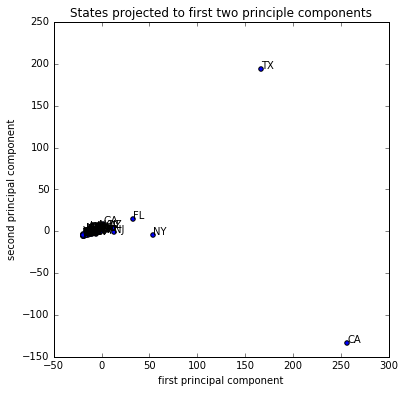

In [17]:
from sklearn.decomposition import RandomizedPCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)
pca = RandomizedPCA(n_components = 2)
pca.fit(X)
X_pca = pca.transform(X)

fig = plt.figure(figsize = (6,6))
plt.scatter(X_pca[:,0],X_pca[:,1])
# plt.xlim([-1,2])
# plt.ylim([-2,3])
for i in range(len(states)):
    plt.annotate(states[i], (X_pca[i,0], X_pca[i,1]))
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.title("States projected to first two principle components")
plt.show()

It is interesting to observe CA and TX being obvious outliers. We have squeezed many dimansions into only two therefore it not easy to comment on the meaning of principle componenets. However it is tempting to conclude that the first principal component is directly proportional to the Hispanic population since both CA and TX has huge values in that direction. And with taking the rist of getting ahead of ourselves we can say that the other direction could well be related to the Asian population percentage. And it is not surprising to see CA having the largest coefficient in that direction: (https://en.wikipedia.org/wiki/Demographics_of_Asian_Americans). 

Now let's remove NY, FL, CA and TX from the data set, standardize the features and zoom into that big cluster:

In [18]:
ind2keep = [i for i in range(len(states)) if states[i] not in ['NY', 'FL', 'CA', 'TX']]
X_pca = X_pca[ind2keep,:]
states = [states[i] for i in ind2keep]

In [19]:
X_pca = StandardScaler().fit_transform(X_pca)

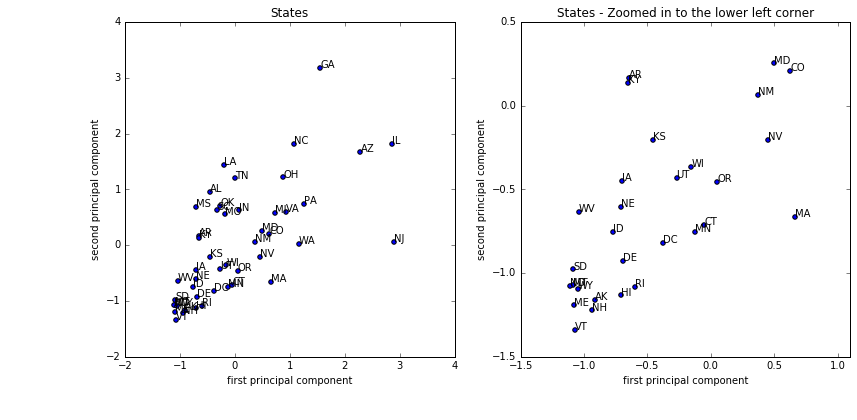

In [20]:
fig = plt.figure(figsize = (13,6))

ax1 = plt.subplot(121)
ax1.scatter(X_pca[:,0],X_pca[:,1])
# plt.xlim([-1,2])
# plt.ylim([-2,3])
for i in range(len(states)):
    ax1.annotate(states[i], (X_pca[i,0], X_pca[i,1]))
ax1.set_xlabel("first principal component")
ax1.set_ylabel("second principal component")
ax1.set_title('States')

ax2 = plt.subplot(122)
ax2.scatter(X_pca[:,0],X_pca[:,1])
ax2.set_xlim([-1.5,1.1])
ax2.set_ylim([-1.5,0.5])
for i in range(len(states)):
    ax2.annotate(states[i], (X_pca[i,0], X_pca[i,1]))
ax2.set_xlabel("first principal component")
ax2.set_ylabel("second principal component")
ax2.set_title('States - Zoomed in to the lower left corner')
plt.show()

Finally we employ a K-means clustering algorithm to the data with reduced to 2 dimensions. 

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, init='k-means++')
kmeans.fit(X_pca)
y_pred = kmeans.predict(X_pca) 

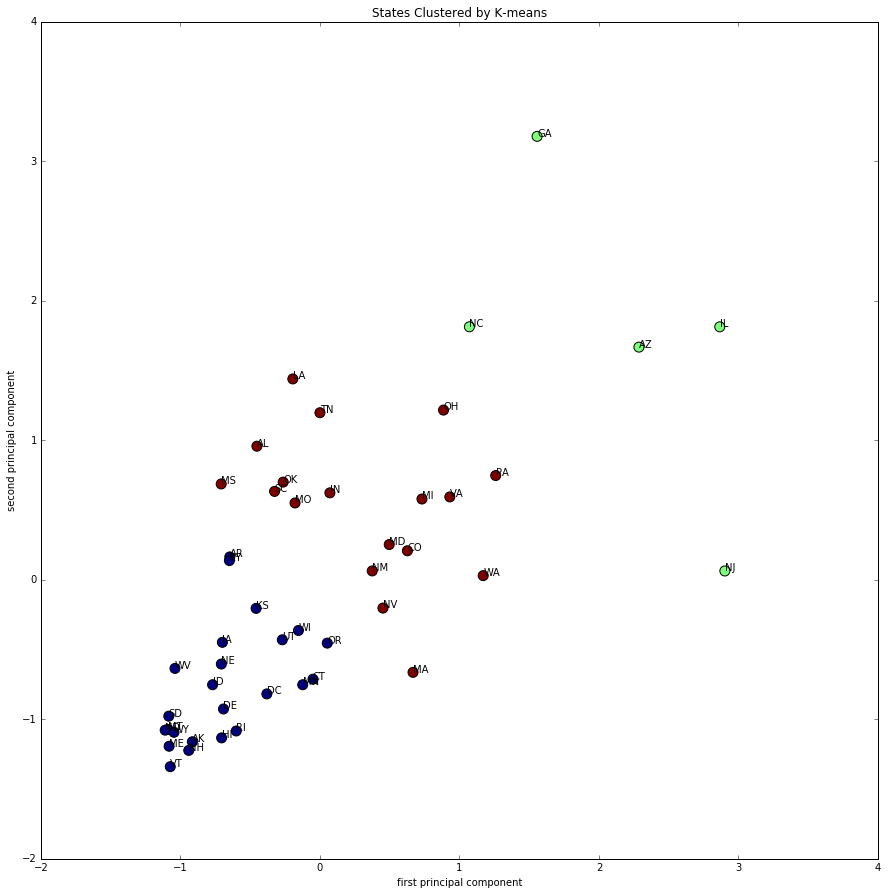

In [22]:
fig = plt.figure(figsize = (15,15))

ax1 = plt.subplot(111)
ax1.scatter(X_pca[:,0],X_pca[:,1], c = y_pred, s= 100)
for i in range(len(states)):
    ax1.annotate(states[i], (X_pca[i,0], X_pca[i,1]))
ax1.set_xlabel("first principal component")
ax1.set_ylabel("second principal component")
ax1.set_title('States Clustered by K-means')
plt.show()


We'll conclude by listing the states under each cluster. For that aim we downloaded a csv file from http://www.fonz.net/blog/archives/2008/04/06/csv-of-states-and-state-abbreviations/ that contains state names and their abbreviations. Let's load that file and get a map of abbreviations to full state names.

In [23]:
state_dict = {}
import re
with open('states.csv', 'r') as f:
    for line in f:
        name, abbrv =  re.sub('["\n]', '', line).split(',')
        state_dict[abbrv] = name

Finally, let's list the states under each cluster:

In [24]:
print('Blue cluster:')
print('--------------')
print(', '.join([state_dict[states[i]] for i in range(len(states)) if y_pred[i] == 0 ]))

print('\nGreen cluster:')
print('--------------')
print(', '.join([state_dict[states[i]] for i in range(len(states)) if y_pred[i] == 1 ]))

print('\nRed cluster:')
print('--------------')
print(', '.join([state_dict[states[i]] for i in range(len(states)) if y_pred[i] == 2 ]))

Blue cluster:
--------------
Alaska, Arkansas, Connecticut, District of Columbia, Delaware, Hawaii, Iowa, Idaho, Kansas, Kentucky, Maine, Minnesota, Montana, North Dakota, Nebraska, New Hampshire, Oregon, Rhode Island, South Dakota, Utah, Vermont, Wisconsin, West Virginia, Wyoming

Green cluster:
--------------
Arizona, Georgia, Illinois, North Carolina, New Jersey

Red cluster:
--------------
Alabama, Colorado, Indiana, Louisiana, Massachusetts, Maryland, Michigan, Missouri, Mississippi, New Mexico, Nevada, Ohio, Oklahoma, Pennsylvania, South Carolina, Tennessee, Virginia, Washington


We'll avoid trying to give too much isight looking at these clusters as we mentioned before a lot of dimentions are pressed into two and it is questionable if these clusters are meaningful in an obvious sense.

#### Some ideas for further investigation:

If we had more time there it'd have been possible to extract other interesting information from this data set. Here are two examples that come to mind:

- State by state population change.
- Analyis of diversity and demographics of immigration.
- More informed cluster analysis by classification of names into demographics.

In [25]:
!ipython nbconvert baby_names.ipynb

[NbConvertApp] Converting notebook baby_names.ipynb to html
[NbConvertApp] Writing 380740 bytes to baby_names.html
